In [1]:
from collections import defaultdict
import pathlib
import pickle

import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch

from train import train
from utils.training import TrainConfig

/home/pavel/.venv/hse/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/pavel/.venv/hse/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
TIMESTAMPS_PER_MONTH = 10

In [4]:
dumps_path = pathlib.Path("dumps")
if not dumps_path.exists():
    dumps_path.mkdir()

# Plan

## Data

1. Years: 2018–2022.
2. Each year: N fields.
3. Each field:
  - features: time series of 10 Sentinel-2 bands (median value for each field), number of timestamps is different;
  - target: crop class label (13 classes).

## Models

1. Classical ML:
  - Random Forest;
  - Catboost;
  - LightGBM.
2. Deep learning:
  - Transformer;
  - TempCNN;
  - *EarlyRNN*.
 
## Training&evaluation workflow

1. For all models besides EarlyRNN: make datasets of reduced size (1–6 months, where 6 months is full-length time series), train models separately on each of them.
2. For EarlyRNN: train using full-length time series.
3. Compare accuracy, precision, recall, f1-score, kappa.

# Part 1. Training

## Classical Machine Learning

### Random Forest

In [5]:
rf_hyperparameters = {
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 21),
}

rf_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    rf_train_params = TrainConfig(        
        model="rf",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength,
        hyperparameters=rf_hyperparameter
    )
    best_model, stats = train(rf_train_params)
    rf_results[n_months]["best_model"] = best_model
    rf_results[n_months]["stats"] = stats

Data: train, year: 2018, months: 1
Loading from cache
# of fields: 7367
Data: test, year: 2018, months: 1
Loading from cache
# of fields: 1566
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END max_depth=19, n_estimators=280; accuracy: (test=0.423) fscore: (test=0.385) kappa: (test=0.293) precision: (test=0.382) recall: (test=0.423) total time=  27.1s
[CV 3/3] END max_depth=7, n_estimators=320; accuracy: (test=0.424) fscore: (test=0.373) kappa: (test=0.288) precision: (test=0.368) recall: (test=0.424) total time=  22.3s
[CV 1/3] END max_depth=3, n_estimators=400; accuracy: (test=0.410) fscore: (test=0.293) kappa: (test=0.229) precision: (test=0.289) recall: (test=0.410) total time=  12.0s
[CV 2/3] END max_depth=3, n_estimators=400; accuracy: (test=0.378) fscore: (test=0.302) kappa: (test=0.215) precision: (test=0.269) recall: (test=0.378) total time=  10.2s
[CV 2/3] END max_depth=17, n_estimators=320; accuracy: (test=0.439)

[CV 1/3] END max_depth=4, n_estimators=210; accuracy: (test=0.414) fscore: (test=0.314) kappa: (test=0.242) precision: (test=0.299) recall: (test=0.414) total time=   7.6s
[CV 3/3] END max_depth=19, n_estimators=280; accuracy: (test=0.423) fscore: (test=0.402) kappa: (test=0.298) precision: (test=0.407) recall: (test=0.423) total time=  29.4s
[CV 2/3] END max_depth=14, n_estimators=390; accuracy: (test=0.440) fscore: (test=0.423) kappa: (test=0.322) precision: (test=0.426) recall: (test=0.440) total time=  34.0s
[CV 3/3] END max_depth=3, n_estimators=400; accuracy: (test=0.409) fscore: (test=0.310) kappa: (test=0.246) precision: (test=0.362) recall: (test=0.409) total time=  10.3s
[CV 1/3] END max_depth=8, n_estimators=500; accuracy: (test=0.424) fscore: (test=0.370) kappa: (test=0.286) precision: (test=0.368) recall: (test=0.424) total time=  28.2s
[CV 2/3] END max_depth=5, n_estimators=110; accuracy: (test=0.406) fscore: (test=0.367) kappa: (test=0.272) precision: (test=0.362) recall

[CV 3/3] END max_depth=4, n_estimators=210; accuracy: (test=0.413) fscore: (test=0.322) kappa: (test=0.259) precision: (test=0.321) recall: (test=0.413) total time=   7.6s
[CV 1/3] END max_depth=7, n_estimators=320; accuracy: (test=0.423) fscore: (test=0.362) kappa: (test=0.280) precision: (test=0.366) recall: (test=0.423) total time=  19.1s
[CV 2/3] END max_depth=7, n_estimators=320; accuracy: (test=0.425) fscore: (test=0.391) kappa: (test=0.297) precision: (test=0.387) recall: (test=0.425) total time=  20.7s
[CV 3/3] END max_depth=14, n_estimators=390; accuracy: (test=0.429) fscore: (test=0.403) kappa: (test=0.304) precision: (test=0.410) recall: (test=0.429) total time=  32.0s
[CV 3/3] END max_depth=17, n_estimators=320; accuracy: (test=0.424) fscore: (test=0.402) kappa: (test=0.300) precision: (test=0.413) recall: (test=0.424) total time=  25.9s
[CV 1/3] END max_depth=5, n_estimators=110; accuracy: (test=0.427) fscore: (test=0.337) kappa: (test=0.270) precision: (test=0.341) recall

Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [01:34<00:00, 87.10it/s]


# of fields: 8264
Data: test, year: 2018, months: 2
Reading from disk
Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057/2057 [00:20<00:00, 98.28it/s]


# of fields: 2057
X shape: (8264, 200) y shape: (8264,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END max_depth=10, n_estimators=30; accuracy: (test=0.433) fscore: (test=0.415) kappa: (test=0.313) precision: (test=0.411) recall: (test=0.433) total time=   2.0s
[CV 1/3] END max_depth=13, n_estimators=500; accuracy: (test=0.420) fscore: (test=0.380) kappa: (test=0.288) precision: (test=0.377) recall: (test=0.420) total time=  38.8s
[CV 3/3] END max_depth=8, n_estimators=310; accuracy: (test=0.429) fscore: (test=0.383) kappa: (test=0.296) precision: (test=0.381) recall: (test=0.429) total time=  17.5s
[CV 1/3] END max_depth=7, n_estimators=140; accuracy: (test=0.426) fscore: (test=0.365) kappa: (test=0.284) precision: (test=0.369) recall: (test=0.426) total time=   7.1s
[CV 2/3] END max_depth=7, n_estimators=140; accuracy: (test=0.423) fscore: (test=0.388) kappa: (test=0.295) precision: (test=0.382) recall: (test=0.423) total time=   7.1s
[CV 2/3] END max_dep

[CV 2/3] END max_depth=9, n_estimators=30; accuracy: (test=0.430) fscore: (test=0.403) kappa: (test=0.305) precision: (test=0.423) recall: (test=0.430) total time=   1.9s
[CV 3/3] END max_depth=9, n_estimators=30; accuracy: (test=0.428) fscore: (test=0.393) kappa: (test=0.299) precision: (test=0.396) recall: (test=0.428) total time=   2.0s
[CV 1/3] END max_depth=13, n_estimators=440; accuracy: (test=0.423) fscore: (test=0.384) kappa: (test=0.293) precision: (test=0.382) recall: (test=0.423) total time=  34.6s
[CV 2/3] END max_depth=3, n_estimators=450; accuracy: (test=0.377) fscore: (test=0.301) kappa: (test=0.215) precision: (test=0.265) recall: (test=0.377) total time=  11.6s
[CV 1/3] END max_depth=10, n_estimators=410; accuracy: (test=0.424) fscore: (test=0.378) kappa: (test=0.290) precision: (test=0.377) recall: (test=0.424) total time=  27.4s
[CV 2/3] END max_depth=17, n_estimators=400; accuracy: (test=0.441) fscore: (test=0.423) kappa: (test=0.323) precision: (test=0.421) recall:

[CV 3/3] END max_depth=15, n_estimators=270; accuracy: (test=0.419) fscore: (test=0.396) kappa: (test=0.292) precision: (test=0.407) recall: (test=0.419) total time=  23.9s
[CV 1/3] END max_depth=19, n_estimators=270; accuracy: (test=0.416) fscore: (test=0.377) kappa: (test=0.284) precision: (test=0.374) recall: (test=0.416) total time=  27.3s
[CV 1/3] END max_depth=9, n_estimators=150; accuracy: (test=0.424) fscore: (test=0.374) kappa: (test=0.288) precision: (test=0.371) recall: (test=0.424) total time=   9.7s
[CV 1/3] END max_depth=5, n_estimators=370; accuracy: (test=0.419) fscore: (test=0.336) kappa: (test=0.261) precision: (test=0.346) recall: (test=0.419) total time=  15.3s
[CV 2/3] END max_depth=19, n_estimators=440; accuracy: (test=0.438) fscore: (test=0.422) kappa: (test=0.319) precision: (test=0.417) recall: (test=0.438) total time=  39.4s
[CV 3/3] END max_depth=12, n_estimators=440; accuracy: (test=0.423) fscore: (test=0.396) kappa: (test=0.296) precision: (test=0.400) reca

[CV 3/3] END max_depth=19, n_estimators=20; accuracy: (test=0.428) fscore: (test=0.422) kappa: (test=0.320) precision: (test=0.427) recall: (test=0.428) total time=   4.7s
[CV 1/3] END max_depth=5, n_estimators=210; accuracy: (test=0.455) fscore: (test=0.377) kappa: (test=0.317) precision: (test=0.380) recall: (test=0.455) total time=  20.3s
[CV 3/3] END max_depth=5, n_estimators=210; accuracy: (test=0.440) fscore: (test=0.371) kappa: (test=0.314) precision: (test=0.361) recall: (test=0.440) total time=  22.1s
[CV 3/3] END max_depth=17, n_estimators=120; accuracy: (test=0.448) fscore: (test=0.433) kappa: (test=0.341) precision: (test=0.444) recall: (test=0.448) total time=  25.2s
[CV 1/3] END max_depth=6, n_estimators=190; accuracy: (test=0.465) fscore: (test=0.397) kappa: (test=0.336) precision: (test=0.404) recall: (test=0.465) total time=  22.2s
[CV 2/3] END max_depth=6, n_estimators=190; accuracy: (test=0.464) fscore: (test=0.393) kappa: (test=0.333) precision: (test=0.429) recall:

Fitting best model on whole train dataset
Data: train, year: 2018, months: 3
Reading from disk
Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [01:55<00:00, 71.54it/s]


# of fields: 8264
Data: test, year: 2018, months: 3
Reading from disk
Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057/2057 [00:28<00:00, 71.41it/s]


# of fields: 2057
X shape: (8264, 300) y shape: (8264,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END max_depth=4, n_estimators=140; accuracy: (test=0.435) fscore: (test=0.351) kappa: (test=0.294) precision: (test=0.324) recall: (test=0.435) total time=   9.8s
[CV 1/3] END max_depth=7, n_estimators=400; accuracy: (test=0.480) fscore: (test=0.425) kappa: (test=0.360) precision: (test=0.441) recall: (test=0.480) total time=  43.7s
[CV 1/3] END max_depth=17, n_estimators=450; accuracy: (test=0.490) fscore: (test=0.451) kappa: (test=0.381) precision: (test=0.452) recall: (test=0.490) total time= 1.2min
[CV 2/3] END max_depth=15, n_estimators=260; accuracy: (test=0.493) fscore: (test=0.456) kappa: (test=0.382) precision: (test=0.448) recall: (test=0.493) total time= 1.0min
[CV 3/3] END max_depth=13, n_estimators=200; accuracy: (test=0.446) fscore: (test=0.428) kappa: (test=0.337) precision: (test=0.443) recall: (test=0.446) total time=  43.1s
[CV 1/3] END max_d

[CV 3/3] END max_depth=6, n_estimators=490; accuracy: (test=0.443) fscore: (test=0.390) kappa: (test=0.323) precision: (test=0.427) recall: (test=0.443) total time=  51.8s
[CV 1/3] END max_depth=13, n_estimators=170; accuracy: (test=0.490) fscore: (test=0.453) kappa: (test=0.380) precision: (test=0.458) recall: (test=0.490) total time=  29.6s
[CV 2/3] END max_depth=9, n_estimators=290; accuracy: (test=0.485) fscore: (test=0.441) kappa: (test=0.367) precision: (test=0.446) recall: (test=0.485) total time=  42.5s
[CV 3/3] END max_depth=11, n_estimators=500; accuracy: (test=0.453) fscore: (test=0.429) kappa: (test=0.343) precision: (test=0.448) recall: (test=0.453) total time= 1.1min
[CV 2/3] END max_depth=14, n_estimators=340; accuracy: (test=0.495) fscore: (test=0.458) kappa: (test=0.384) precision: (test=0.456) recall: (test=0.495) total time=  50.7s
[CV 3/3] END max_depth=19, n_estimators=270; accuracy: (test=0.452) fscore: (test=0.439) kappa: (test=0.346) precision: (test=0.451) reca

[CV 1/3] END max_depth=13, n_estimators=370; accuracy: (test=0.490) fscore: (test=0.451) kappa: (test=0.381) precision: (test=0.457) recall: (test=0.490) total time=  50.3s
[CV 2/3] END max_depth=19, n_estimators=210; accuracy: (test=0.495) fscore: (test=0.460) kappa: (test=0.386) precision: (test=0.455) recall: (test=0.495) total time=  31.1s
[CV 3/3] END max_depth=18, n_estimators=280; accuracy: (test=0.452) fscore: (test=0.439) kappa: (test=0.346) precision: (test=0.448) recall: (test=0.452) total time=  41.3s
[CV 1/3] END max_depth=12, n_estimators=360; accuracy: (test=0.490) fscore: (test=0.449) kappa: (test=0.379) precision: (test=0.458) recall: (test=0.490) total time=  48.2s
[CV 3/3] END max_depth=7, n_estimators=190; accuracy: (test=0.447) fscore: (test=0.402) kappa: (test=0.329) precision: (test=0.433) recall: (test=0.447) total time=  15.9s
[CV 3/3] END max_depth=14, n_estimators=260; accuracy: (test=0.457) fscore: (test=0.440) kappa: (test=0.350) precision: (test=0.453) rec

[CV 3/3] END max_depth=8, n_estimators=490; accuracy: (test=0.478) fscore: (test=0.451) kappa: (test=0.374) precision: (test=0.473) recall: (test=0.478) total time= 1.2min
[CV 2/3] END max_depth=15, n_estimators=160; accuracy: (test=0.562) fscore: (test=0.537) kappa: (test=0.469) precision: (test=0.543) recall: (test=0.562) total time=  34.4s
[CV 1/3] END max_depth=16, n_estimators=260; accuracy: (test=0.575) fscore: (test=0.541) kappa: (test=0.483) precision: (test=0.550) recall: (test=0.575) total time= 1.1min
[CV 3/3] END max_depth=3, n_estimators=240; accuracy: (test=0.424) fscore: (test=0.365) kappa: (test=0.288) precision: (test=0.372) recall: (test=0.424) total time=  17.1s
[CV 2/3] END max_depth=14, n_estimators=400; accuracy: (test=0.553) fscore: (test=0.528) kappa: (test=0.457) precision: (test=0.537) recall: (test=0.553) total time= 1.6min
[CV 1/3] END max_depth=7, n_estimators=100; accuracy: (test=0.537) fscore: (test=0.489) kappa: (test=0.429) precision: (test=0.511) recal

Preprocessing features
Preparing X and y


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 7635/8264 [02:02<00:10, 61.89it/s]

[CV 1/3] END max_depth=8, n_estimators=310; accuracy: (test=0.547) fscore: (test=0.502) kappa: (test=0.444) precision: (test=0.515) recall: (test=0.547) total time=  37.6s
[CV 2/3] END max_depth=8, n_estimators=310; accuracy: (test=0.521) fscore: (test=0.488) kappa: (test=0.413) precision: (test=0.526) recall: (test=0.521) total time=  37.9s
[CV 3/3] END max_depth=7, n_estimators=480; accuracy: (test=0.470) fscore: (test=0.436) kappa: (test=0.362) precision: (test=0.463) recall: (test=0.470) total time=  47.5s
[CV 1/3] END max_depth=10, n_estimators=470; accuracy: (test=0.561) fscore: (test=0.521) kappa: (test=0.464) precision: (test=0.534) recall: (test=0.561) total time= 1.0min
[CV 2/3] END max_depth=13, n_estimators=440; accuracy: (test=0.551) fscore: (test=0.524) kappa: (test=0.454) precision: (test=0.534) recall: (test=0.551) total time= 1.1min
[CV 3/3] END max_depth=10, n_estimators=410; accuracy: (test=0.485) fscore: (test=0.464) kappa: (test=0.385) precision: (test=0.479) recal

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 7767/8264 [02:05<00:08, 58.16it/s]

[CV 1/3] END max_depth=19, n_estimators=440; accuracy: (test=0.579) fscore: (test=0.543) kappa: (test=0.488) precision: (test=0.550) recall: (test=0.579) total time= 1.2min
[CV 2/3] END max_depth=12, n_estimators=440; accuracy: (test=0.551) fscore: (test=0.526) kappa: (test=0.455) precision: (test=0.538) recall: (test=0.551) total time= 1.0min
[CV 1/3] END max_depth=13, n_estimators=260; accuracy: (test=0.567) fscore: (test=0.531) kappa: (test=0.473) precision: (test=0.535) recall: (test=0.567) total time=  38.8s
[CV 3/3] END max_depth=6, n_estimators=250; accuracy: (test=0.459) fscore: (test=0.418) kappa: (test=0.346) precision: (test=0.420) recall: (test=0.459) total time=  21.2s
[CV 1/3] END max_depth=4, n_estimators=170; accuracy: (test=0.444) fscore: (test=0.363) kappa: (test=0.294) precision: (test=0.394) recall: (test=0.444) total time=  10.2s
[CV 2/3] END max_depth=4, n_estimators=170; accuracy: (test=0.456) fscore: (test=0.400) kappa: (test=0.330) precision: (test=0.378) recal

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [02:12<00:00, 62.19it/s]


# of fields: 8264[CV 3/3] END max_depth=12, n_estimators=450; accuracy: (test=0.488) fscore: (test=0.471) kappa: (test=0.390) precision: (test=0.485) recall: (test=0.488) total time= 1.7min
[CV 2/3] END max_depth=12, n_estimators=40; accuracy: (test=0.534) fscore: (test=0.510) kappa: (test=0.435) precision: (test=0.514) recall: (test=0.534) total time=   7.4s
[CV 1/3] END max_depth=10, n_estimators=30; accuracy: (test=0.540) fscore: (test=0.503) kappa: (test=0.440) precision: (test=0.507) recall: (test=0.540) total time=   4.7s
[CV 2/3] END max_depth=10, n_estimators=30; accuracy: (test=0.526) fscore: (test=0.500) kappa: (test=0.424) precision: (test=0.515) recall: (test=0.526) total time=   5.9s
[CV 1/3] END max_depth=13, n_estimators=500; accuracy: (test=0.573) fscore: (test=0.535) kappa: (test=0.480) precision: (test=0.544) recall: (test=0.573) total time= 1.5min
[CV 1/3] END max_depth=7, n_estimators=480; accuracy: (test=0.538) fscore: (test=0.490) kappa: (test=0.430) precision: (t

 37%|████████████████████████████████████████▍                                                                     | 757/2057 [00:12<00:19, 67.58it/s]

[CV 3/3] END max_depth=13, n_estimators=460; accuracy: (test=0.492) fscore: (test=0.477) kappa: (test=0.395) precision: (test=0.491) recall: (test=0.492) total time= 1.2min
[CV 1/3] END max_depth=10, n_estimators=490; accuracy: (test=0.565) fscore: (test=0.526) kappa: (test=0.469) precision: (test=0.540) recall: (test=0.565) total time= 1.5min
[CV 3/3] END max_depth=4, n_estimators=270; accuracy: (test=0.438) fscore: (test=0.382) kappa: (test=0.314) precision: (test=0.364) recall: (test=0.438) total time=  23.0s
[CV 2/3] END max_depth=6, n_estimators=470; accuracy: (test=0.492) fscore: (test=0.441) kappa: (test=0.376) precision: (test=0.478) recall: (test=0.492) total time=  55.3s
[CV 3/3] END max_depth=15, n_estimators=320; accuracy: (test=0.488) fscore: (test=0.472) kappa: (test=0.390) precision: (test=0.481) recall: (test=0.488) total time=  50.2s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057/2057 [00:30<00:00, 67.26it/s]


# of fields: 2057
X shape: (8264, 400) y shape: (8264,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END max_depth=19, n_estimators=280; accuracy: (test=0.644) fscore: (test=0.614) kappa: (test=0.569) precision: (test=0.623) recall: (test=0.644) total time= 1.3min
[CV 3/3] END max_depth=7, n_estimators=320; accuracy: (test=0.569) fscore: (test=0.540) kappa: (test=0.482) precision: (test=0.560) recall: (test=0.569) total time=  51.8s
[CV 1/3] END max_depth=3, n_estimators=400; accuracy: (test=0.438) fscore: (test=0.349) kappa: (test=0.283) precision: (test=0.315) recall: (test=0.438) total time=  29.3s
[CV 2/3] END max_depth=3, n_estimators=400; accuracy: (test=0.474) fscore: (test=0.408) kappa: (test=0.345) precision: (test=0.434) recall: (test=0.474) total time=  29.7s
[CV 1/3] END max_depth=17, n_estimators=320; accuracy: (test=0.645) fscore: (test=0.616) kappa: (test=0.570) precision: (test=0.621) recall: (test=0.645) total time= 1.4min
[CV 2/3] END max_de

[CV 2/3] END max_depth=4, n_estimators=210; accuracy: (test=0.510) fscore: (test=0.467) kappa: (test=0.403) precision: (test=0.498) recall: (test=0.510) total time=  23.9s
[CV 1/3] END max_depth=7, n_estimators=320; accuracy: (test=0.609) fscore: (test=0.570) kappa: (test=0.521) precision: (test=0.590) recall: (test=0.609) total time=  47.3s
[CV 2/3] END max_depth=7, n_estimators=320; accuracy: (test=0.586) fscore: (test=0.557) kappa: (test=0.501) precision: (test=0.573) recall: (test=0.586) total time=  50.1s
[CV 3/3] END max_depth=14, n_estimators=390; accuracy: (test=0.600) fscore: (test=0.583) kappa: (test=0.522) precision: (test=0.619) recall: (test=0.600) total time= 1.6min
[CV 3/3] END max_depth=17, n_estimators=320; accuracy: (test=0.610) fscore: (test=0.593) kappa: (test=0.533) precision: (test=0.625) recall: (test=0.610) total time= 1.4min
[CV 1/3] END max_depth=5, n_estimators=110; accuracy: (test=0.547) fscore: (test=0.502) kappa: (test=0.437) precision: (test=0.527) recall

[CV 1/3] END max_depth=4, n_estimators=210; accuracy: (test=0.476) fscore: (test=0.403) kappa: (test=0.338) precision: (test=0.423) recall: (test=0.476) total time=  23.3s
[CV 3/3] END max_depth=19, n_estimators=280; accuracy: (test=0.602) fscore: (test=0.586) kappa: (test=0.524) precision: (test=0.613) recall: (test=0.602) total time= 1.2min
[CV 1/3] END max_depth=14, n_estimators=390; accuracy: (test=0.644) fscore: (test=0.614) kappa: (test=0.569) precision: (test=0.622) recall: (test=0.644) total time= 1.6min
[CV 2/3] END max_depth=17, n_estimators=320; accuracy: (test=0.649) fscore: (test=0.627) kappa: (test=0.578) precision: (test=0.635) recall: (test=0.649) total time= 1.4min
[CV 3/3] END max_depth=8, n_estimators=500; accuracy: (test=0.577) fscore: (test=0.550) kappa: (test=0.492) precision: (test=0.588) recall: (test=0.577) total time= 1.4min
[CV 3/3] END max_depth=4, n_estimators=370; accuracy: (test=0.476) fscore: (test=0.443) kappa: (test=0.358) precision: (test=0.470) recal

Preprocessing features
Preparing X and y


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 7302/8264 [01:37<00:14, 68.57it/s]

[CV 3/3] END max_depth=3, n_estimators=450; accuracy: (test=0.427) fscore: (test=0.357) kappa: (test=0.284) precision: (test=0.418) recall: (test=0.427) total time=  35.9s
[CV 2/3] END max_depth=10, n_estimators=410; accuracy: (test=0.619) fscore: (test=0.597) kappa: (test=0.542) precision: (test=0.620) recall: (test=0.619) total time= 1.3min
[CV 3/3] END max_depth=17, n_estimators=400; accuracy: (test=0.606) fscore: (test=0.590) kappa: (test=0.529) precision: (test=0.623) recall: (test=0.606) total time= 1.5min
[CV 1/3] END max_depth=7, n_estimators=90; accuracy: (test=0.608) fscore: (test=0.569) kappa: (test=0.520) precision: (test=0.580) recall: (test=0.608) total time=  13.3s
[CV 2/3] END max_depth=7, n_estimators=90; accuracy: (test=0.588) fscore: (test=0.560) kappa: (test=0.503) precision: (test=0.600) recall: (test=0.588) total time=  18.5s
[CV 1/3] END max_depth=6, n_estimators=490; accuracy: (test=0.592) fscore: (test=0.552) kappa: (test=0.498) precision: (test=0.600) recall: 

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 7442/8264 [01:39<00:12, 66.05it/s]

[CV 3/3] END max_depth=5, n_estimators=370; accuracy: (test=0.528) fscore: (test=0.500) kappa: (test=0.428) precision: (test=0.516) recall: (test=0.528) total time=  35.1s
[CV 1/3] END max_depth=10, n_estimators=120; accuracy: (test=0.641) fscore: (test=0.608) kappa: (test=0.564) precision: (test=0.615) recall: (test=0.641) total time=  18.0s
[CV 2/3] END max_depth=10, n_estimators=120; accuracy: (test=0.617) fscore: (test=0.594) kappa: (test=0.539) precision: (test=0.611) recall: (test=0.617) total time=  17.9s
[CV 3/3] END max_depth=10, n_estimators=120; accuracy: (test=0.591) fscore: (test=0.570) kappa: (test=0.510) precision: (test=0.614) recall: (test=0.591) total time=  18.3s
[CV 1/3] END max_depth=12, n_estimators=440; accuracy: (test=0.638) fscore: (test=0.607) kappa: (test=0.560) precision: (test=0.618) recall: (test=0.638) total time= 1.2min
[CV 2/3] END max_depth=16, n_estimators=150; accuracy: (test=0.641) fscore: (test=0.618) kappa: (test=0.569) precision: (test=0.627) rec

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [01:50<00:00, 74.74it/s]


# of fields: 8264
Data: test, year: 2018, months: 5
Reading from disk
Preprocessing features
Preparing X and y


 16%|█████████████████▊                                                                                            | 334/2057 [00:03<00:20, 83.68it/s]

[CV 2/3] END max_depth=16, n_estimators=190; accuracy: (test=0.647) fscore: (test=0.626) kappa: (test=0.576) precision: (test=0.635) recall: (test=0.647) total time=  44.7s
[CV 3/3] END max_depth=13, n_estimators=170; accuracy: (test=0.601) fscore: (test=0.586) kappa: (test=0.523) precision: (test=0.620) recall: (test=0.601) total time=  38.3s
[CV 1/3] END max_depth=11, n_estimators=500; accuracy: (test=0.642) fscore: (test=0.610) kappa: (test=0.565) precision: (test=0.614) recall: (test=0.642) total time= 1.5min
[CV 2/3] END max_depth=15, n_estimators=270; accuracy: (test=0.643) fscore: (test=0.621) kappa: (test=0.571) precision: (test=0.630) recall: (test=0.643) total time=  59.4s
[CV 3/3] END max_depth=14, n_estimators=340; accuracy: (test=0.607) fscore: (test=0.591) kappa: (test=0.531) precision: (test=0.626) recall: (test=0.607) total time= 1.2min
[CV 1/3] END max_depth=9, n_estimators=150; accuracy: (test=0.627) fscore: (test=0.593) kappa: (test=0.546) precision: (test=0.599) rec

 44%|████████████████████████████████████████████████▏                                                             | 900/2057 [00:10<00:13, 85.89it/s]

[CV 3/3] END max_depth=5, n_estimators=380; accuracy: (test=0.529) fscore: (test=0.500) kappa: (test=0.428) precision: (test=0.516) recall: (test=0.529) total time=  35.4s
[CV 1/3] END max_depth=9, n_estimators=30; accuracy: (test=0.618) fscore: (test=0.587) kappa: (test=0.535) precision: (test=0.595) recall: (test=0.618) total time=   4.5s
[CV 2/3] END max_depth=9, n_estimators=30; accuracy: (test=0.604) fscore: (test=0.583) kappa: (test=0.523) precision: (test=0.595) recall: (test=0.604) total time=   4.8s
[CV 3/3] END max_depth=9, n_estimators=30; accuracy: (test=0.585) fscore: (test=0.565) kappa: (test=0.503) precision: (test=0.607) recall: (test=0.585) total time=   4.4s
[CV 1/3] END max_depth=13, n_estimators=440; accuracy: (test=0.639) fscore: (test=0.608) kappa: (test=0.562) precision: (test=0.614) recall: (test=0.639) total time= 1.5min
[CV 2/3] END max_depth=3, n_estimators=450; accuracy: (test=0.470) fscore: (test=0.407) kappa: (test=0.341) precision: (test=0.436) recall: (t

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057/2057 [00:22<00:00, 90.64it/s]


# of fields: 2057
X shape: (8264, 500) y shape: (8264,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END max_depth=4, n_estimators=210; accuracy: (test=0.519) fscore: (test=0.483) kappa: (test=0.413) precision: (test=0.533) recall: (test=0.519) total time=  16.8s
[CV 1/3] END max_depth=7, n_estimators=320; accuracy: (test=0.629) fscore: (test=0.593) kappa: (test=0.546) precision: (test=0.618) recall: (test=0.629) total time=  40.4s
[CV 2/3] END max_depth=7, n_estimators=320; accuracy: (test=0.611) fscore: (test=0.583) kappa: (test=0.530) precision: (test=0.631) recall: (test=0.611) total time=  40.4s
[CV 3/3] END max_depth=14, n_estimators=390; accuracy: (test=0.649) fscore: (test=0.630) kappa: (test=0.580) precision: (test=0.656) recall: (test=0.649) total time= 1.3min
[CV 1/3] END max_depth=8, n_estimators=500; accuracy: (test=0.645) fscore: (test=0.614) kappa: (test=0.567) precision: (test=0.639) recall: (test=0.645) total time= 1.2min
[CV 2/3] END max_dep

[CV 1/3] END max_depth=19, n_estimators=280; accuracy: (test=0.687) fscore: (test=0.668) kappa: (test=0.622) precision: (test=0.679) recall: (test=0.687) total time= 1.0min
[CV 3/3] END max_depth=7, n_estimators=320; accuracy: (test=0.603) fscore: (test=0.570) kappa: (test=0.523) precision: (test=0.618) recall: (test=0.603) total time=  40.7s
[CV 1/3] END max_depth=3, n_estimators=400; accuracy: (test=0.428) fscore: (test=0.339) kappa: (test=0.268) precision: (test=0.306) recall: (test=0.428) total time=  24.1s
[CV 2/3] END max_depth=3, n_estimators=400; accuracy: (test=0.490) fscore: (test=0.443) kappa: (test=0.379) precision: (test=0.455) recall: (test=0.490) total time=  24.0s
[CV 3/3] END max_depth=3, n_estimators=400; accuracy: (test=0.464) fscore: (test=0.409) kappa: (test=0.339) precision: (test=0.444) recall: (test=0.464) total time=  24.1s
[CV 3/3] END max_depth=17, n_estimators=320; accuracy: (test=0.647) fscore: (test=0.630) kappa: (test=0.578) precision: (test=0.651) recall

[CV 2/3] END max_depth=4, n_estimators=210; accuracy: (test=0.524) fscore: (test=0.486) kappa: (test=0.422) precision: (test=0.528) recall: (test=0.524) total time=  16.2s
[CV 3/3] END max_depth=19, n_estimators=280; accuracy: (test=0.647) fscore: (test=0.629) kappa: (test=0.578) precision: (test=0.649) recall: (test=0.647) total time=  59.8s
[CV 2/3] END max_depth=14, n_estimators=390; accuracy: (test=0.670) fscore: (test=0.651) kappa: (test=0.604) precision: (test=0.669) recall: (test=0.670) total time= 1.3min
[CV 1/3] END max_depth=17, n_estimators=320; accuracy: (test=0.695) fscore: (test=0.674) kappa: (test=0.631) precision: (test=0.685) recall: (test=0.695) total time= 1.1min
[CV 3/3] END max_depth=8, n_estimators=500; accuracy: (test=0.617) fscore: (test=0.587) kappa: (test=0.540) precision: (test=0.627) recall: (test=0.617) total time= 1.2min
[CV 3/3] END max_depth=4, n_estimators=370; accuracy: (test=0.519) fscore: (test=0.482) kappa: (test=0.412) precision: (test=0.532) recal

Preprocessing features
Preparing X and y


 57%|█████████████████████████████████████████████████████████████▉                                               | 4699/8264 [01:18<00:55, 64.27it/s]

[CV 2/3] END max_depth=6, n_estimators=490; accuracy: (test=0.593) fscore: (test=0.564) kappa: (test=0.509) precision: (test=0.608) recall: (test=0.593) total time=  53.4s
[CV 3/3] END max_depth=16, n_estimators=190; accuracy: (test=0.646) fscore: (test=0.631) kappa: (test=0.577) precision: (test=0.651) recall: (test=0.646) total time=  39.5s
[CV 1/3] END max_depth=9, n_estimators=290; accuracy: (test=0.653) fscore: (test=0.625) kappa: (test=0.577) precision: (test=0.642) recall: (test=0.653) total time=  44.5s
[CV 2/3] END max_depth=11, n_estimators=500; accuracy: (test=0.666) fscore: (test=0.647) kappa: (test=0.599) precision: (test=0.665) recall: (test=0.666) total time= 1.5min
[CV 1/3] END max_depth=14, n_estimators=340; accuracy: (test=0.687) fscore: (test=0.666) kappa: (test=0.622) precision: (test=0.683) recall: (test=0.687) total time= 1.1min
[CV 2/3] END max_depth=19, n_estimators=270; accuracy: (test=0.681) fscore: (test=0.660) kappa: (test=0.618) precision: (test=0.674) reca

 58%|███████████████████████████████████████████████████████████████▋                                             | 4829/8264 [01:20<01:32, 37.14it/s]

[CV 1/3] END max_depth=13, n_estimators=500; accuracy: (test=0.678) fscore: (test=0.654) kappa: (test=0.610) precision: (test=0.669) recall: (test=0.678) total time= 1.6min
[CV 1/3] END max_depth=7, n_estimators=480; accuracy: (test=0.632) fscore: (test=0.596) kappa: (test=0.550) precision: (test=0.634) recall: (test=0.632) total time= 1.0min
[CV 3/3] END max_depth=7, n_estimators=140; accuracy: (test=0.608) fscore: (test=0.576) kappa: (test=0.529) precision: (test=0.624) recall: (test=0.608) total time=  17.6s
[CV 3/3] END max_depth=5, n_estimators=380; accuracy: (test=0.565) fscore: (test=0.534) kappa: (test=0.473) precision: (test=0.539) recall: (test=0.565) total time=  35.6s
[CV 1/3] END max_depth=9, n_estimators=30; accuracy: (test=0.652) fscore: (test=0.625) kappa: (test=0.576) precision: (test=0.634) recall: (test=0.652) total time=   4.6s
[CV 2/3] END max_depth=9, n_estimators=30; accuracy: (test=0.638) fscore: (test=0.618) kappa: (test=0.564) precision: (test=0.635) recall: (

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 5342/8264 [01:32<01:06, 43.94it/s]

[CV 3/3] END max_depth=10, n_estimators=120; accuracy: (test=0.634) fscore: (test=0.612) kappa: (test=0.562) precision: (test=0.642) recall: (test=0.634) total time=  19.7s
[CV 1/3] END max_depth=12, n_estimators=440; accuracy: (test=0.681) fscore: (test=0.659) kappa: (test=0.614) precision: (test=0.673) recall: (test=0.681) total time= 1.4min
[CV 2/3] END max_depth=16, n_estimators=150; accuracy: (test=0.679) fscore: (test=0.662) kappa: (test=0.616) precision: (test=0.677) recall: (test=0.679) total time=  30.4s
[CV 3/3] END max_depth=13, n_estimators=260; accuracy: (test=0.640) fscore: (test=0.621) kappa: (test=0.569) precision: (test=0.648) recall: (test=0.640) total time=  49.7s
[CV 2/3] END max_depth=13, n_estimators=370; accuracy: (test=0.675) fscore: (test=0.655) kappa: (test=0.610) precision: (test=0.673) recall: (test=0.675) total time= 1.2min
[CV 3/3] END max_depth=19, n_estimators=210; accuracy: (test=0.644) fscore: (test=0.628) kappa: (test=0.574) precision: (test=0.646) re

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 6111/8264 [01:44<00:32, 66.22it/s]

[CV 2/3] END max_depth=10, n_estimators=410; accuracy: (test=0.653) fscore: (test=0.633) kappa: (test=0.583) precision: (test=0.652) recall: (test=0.653) total time= 1.1min
[CV 3/3] END max_depth=17, n_estimators=400; accuracy: (test=0.647) fscore: (test=0.629) kappa: (test=0.578) precision: (test=0.657) recall: (test=0.647) total time= 1.4min
[CV 1/3] END max_depth=7, n_estimators=90; accuracy: (test=0.624) fscore: (test=0.587) kappa: (test=0.539) precision: (test=0.613) recall: (test=0.624) total time=  11.5s
[CV 2/3] END max_depth=7, n_estimators=90; accuracy: (test=0.605) fscore: (test=0.579) kappa: (test=0.524) precision: (test=0.618) recall: (test=0.605) total time=  11.2s
[CV 1/3] END max_depth=6, n_estimators=490; accuracy: (test=0.607) fscore: (test=0.565) kappa: (test=0.517) precision: (test=0.603) recall: (test=0.607) total time=  53.3s
[CV 1/3] END max_depth=16, n_estimators=190; accuracy: (test=0.686) fscore: (test=0.664) kappa: (test=0.620) precision: (test=0.673) recall:

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8264/8264 [02:20<00:00, 58.97it/s]


# of fields: 8264
Data: test, year: 2018, months: 6
Reading from disk
Preprocessing features
Preparing X and y


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2057/2057 [00:24<00:00, 84.21it/s]


# of fields: 2057
X shape: (8264, 600) y shape: (8264,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END max_depth=4, n_estimators=210; accuracy: (test=0.504) fscore: (test=0.469) kappa: (test=0.394) precision: (test=0.534) recall: (test=0.504) total time=  20.9s
[CV 3/3] END max_depth=19, n_estimators=280; accuracy: (test=0.644) fscore: (test=0.626) kappa: (test=0.575) precision: (test=0.647) recall: (test=0.644) total time= 1.5min
[CV 2/3] END max_depth=14, n_estimators=390; accuracy: (test=0.664) fscore: (test=0.650) kappa: (test=0.598) precision: (test=0.661) recall: (test=0.664) total time= 1.9min
[CV 2/3] END max_depth=17, n_estimators=320; accuracy: (test=0.672) fscore: (test=0.657) kappa: (test=0.608) precision: (test=0.664) recall: (test=0.672) total time= 1.4min
[CV 2/3] END max_depth=8, n_estimators=500; accuracy: (test=0.620) fscore: (test=0.601) kappa: (test=0.544) precision: (test=0.619) recall: (test=0.620) total time= 1.4min
[CV 2/3] END max_d

[CV 1/3] END max_depth=19, n_estimators=280; accuracy: (test=0.695) fscore: (test=0.676) kappa: (test=0.631) precision: (test=0.686) recall: (test=0.695) total time= 1.4min
[CV 3/3] END max_depth=7, n_estimators=320; accuracy: (test=0.608) fscore: (test=0.579) kappa: (test=0.528) precision: (test=0.606) recall: (test=0.608) total time= 1.1min
[CV 1/3] END max_depth=3, n_estimators=400; accuracy: (test=0.436) fscore: (test=0.345) kappa: (test=0.279) precision: (test=0.319) recall: (test=0.436) total time=  32.3s
[CV 2/3] END max_depth=3, n_estimators=400; accuracy: (test=0.490) fscore: (test=0.439) kappa: (test=0.378) precision: (test=0.458) recall: (test=0.490) total time=  32.6s
[CV 3/3] END max_depth=3, n_estimators=400; accuracy: (test=0.458) fscore: (test=0.406) kappa: (test=0.332) precision: (test=0.442) recall: (test=0.458) total time=  31.7s
[CV 1/3] END max_depth=8, n_estimators=500; accuracy: (test=0.649) fscore: (test=0.620) kappa: (test=0.572) precision: (test=0.653) recall:

[CV 2/3] END max_depth=4, n_estimators=210; accuracy: (test=0.525) fscore: (test=0.489) kappa: (test=0.423) precision: (test=0.497) recall: (test=0.525) total time=  20.7s
[CV 2/3] END max_depth=19, n_estimators=280; accuracy: (test=0.674) fscore: (test=0.660) kappa: (test=0.610) precision: (test=0.670) recall: (test=0.674) total time= 1.4min
[CV 1/3] END max_depth=14, n_estimators=390; accuracy: (test=0.690) fscore: (test=0.670) kappa: (test=0.624) precision: (test=0.682) recall: (test=0.690) total time= 1.9min
[CV 1/3] END max_depth=17, n_estimators=320; accuracy: (test=0.692) fscore: (test=0.673) kappa: (test=0.627) precision: (test=0.683) recall: (test=0.692) total time= 1.5min
[CV 3/3] END max_depth=8, n_estimators=500; accuracy: (test=0.621) fscore: (test=0.593) kappa: (test=0.544) precision: (test=0.619) recall: (test=0.621) total time= 1.4min
[CV 3/3] END max_depth=4, n_estimators=370; accuracy: (test=0.507) fscore: (test=0.472) kappa: (test=0.398) precision: (test=0.525) recal

[CV 2/3] END max_depth=5, n_estimators=380; accuracy: (test=0.559) fscore: (test=0.529) kappa: (test=0.467) precision: (test=0.561) recall: (test=0.559) total time=  40.5s
[CV 3/3] END max_depth=10, n_estimators=470; accuracy: (test=0.634) fscore: (test=0.612) kappa: (test=0.561) precision: (test=0.653) recall: (test=0.634) total time= 1.5min
[CV 1/3] END max_depth=3, n_estimators=450; accuracy: (test=0.440) fscore: (test=0.349) kappa: (test=0.284) precision: (test=0.323) recall: (test=0.440) total time=  29.8s
[CV 3/3] END max_depth=3, n_estimators=450; accuracy: (test=0.455) fscore: (test=0.405) kappa: (test=0.329) precision: (test=0.443) recall: (test=0.455) total time=  29.2s
[CV 2/3] END max_depth=10, n_estimators=410; accuracy: (test=0.643) fscore: (test=0.628) kappa: (test=0.572) precision: (test=0.640) recall: (test=0.643) total time= 1.2min
[CV 3/3] END max_depth=17, n_estimators=400; accuracy: (test=0.647) fscore: (test=0.630) kappa: (test=0.579) precision: (test=0.655) recal

[CV 3/3] END max_depth=7, n_estimators=480; accuracy: (test=0.606) fscore: (test=0.578) kappa: (test=0.525) precision: (test=0.610) recall: (test=0.606) total time= 1.1min
[CV 1/3] END max_depth=10, n_estimators=470; accuracy: (test=0.671) fscore: (test=0.650) kappa: (test=0.600) precision: (test=0.669) recall: (test=0.671) total time= 1.5min
[CV 2/3] END max_depth=13, n_estimators=440; accuracy: (test=0.668) fscore: (test=0.652) kappa: (test=0.602) precision: (test=0.662) recall: (test=0.668) total time= 1.6min
[CV 3/3] END max_depth=10, n_estimators=410; accuracy: (test=0.634) fscore: (test=0.611) kappa: (test=0.560) precision: (test=0.644) recall: (test=0.634) total time= 1.3min
[CV 1/3] END max_depth=11, n_estimators=490; accuracy: (test=0.675) fscore: (test=0.654) kappa: (test=0.606) precision: (test=0.670) recall: (test=0.675) total time= 1.6min
[CV 3/3] END max_depth=7, n_estimators=90; accuracy: (test=0.606) fscore: (test=0.578) kappa: (test=0.526) precision: (test=0.618) recal

In [6]:
with open(dumps_path / "rf_results.dump", "wb") as f:
    pickle.dump(rf_results, f)

### LightGBM

In [ ]:
lgbm_hyperparameters = {
    "boosting_type": ("dart",),
    "n_estimators": range(10, 501, 10),
    "max_depth": range(3, 11),
    "learning_rate": (0.001, 0.01, 0.1, 1),
}

lgbm_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    lgbm_train_params = TrainConfig(model="lightgbm", year=2018,
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters=lgbm_hyperparameters)
    best_model, stats = train(lgbm_train_params)
    lgbm_results[n_months]["best_model"] = best_model
    lgbm_results[n_months]["stats"] = stats

Cache is activated and will be used if possible
Data: train, year: 2018
Trying to use cache
Loading X and y from cache
Russia dataset for 2018 year (train part) is loaded. It contains 7367 fields
Cache is activated and will be used if possible
Data: test, year: 2018
Trying to use cache
Loading X and y from cache
Russia dataset for 2018 year (test part) is loaded. It contains 1566 fields
X shape: (7367, 100) y shape: (7367,)
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=10; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=10; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=10; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=60; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=60; total time=   2.0s
[CV] END boosti

[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=110; total time=  19.1s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=110; total time=  22.7s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=110; total time=  21.9s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=160; total time=  31.0s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=160; total time=  18.6s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=160; total time=  18.8s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=210; total time=  23.9s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=210; total time=  23.2s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=210; total time=  25.1s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=260; total time=  31.6s
[CV] END b

[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=10; total time=   0.5s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=10; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=10; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=60; total time=   1.1s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=60; total time=   1.2s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=60; total time=   1.3s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=110; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=110; total time=   2.2s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=110; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=160; total time=   2.5s
[CV] END boosting_type=dart, learning_rate=1, 

[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=110; total time=  23.3s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=160; total time=  37.0s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=160; total time=  34.6s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=160; total time=  36.0s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=210; total time=  49.0s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=210; total time=  48.2s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=210; total time= 1.1min
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=260; total time= 1.3min
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=260; total time= 1.1min
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=6, n_estimators=260; total time=  55.0s


[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=10; total time=   1.0s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.9s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=60; total time=   5.7s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=60; total time=   4.6s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=60; total time=   4.7s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=110; total time=   9.5s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=110; total time=  10.1s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=110; total time=   8.5s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=160; total time=  17.3s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=3, n_estimators=160; total time=  15.0s
[CV] END boosting_type=da

[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=210; total time=   5.1s
[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=260; total time=   6.5s
[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=260; total time=   6.9s
[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=260; total time=   5.9s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=10; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=10; total time=   1.9s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=10; total time=   1.8s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=60; total time=   3.1s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=60; total time=   3.3s
[CV] END boosting_type=dart, learning_rate=1, max_depth=9, n_estimators=60; total time=   2.8s
[CV] END boosting_type=dart, learning_rate=1, 

[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=60; total time=   5.6s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=60; total time=   5.5s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=60; total time=   5.6s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=110; total time=  10.4s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=110; total time=  10.3s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=110; total time=  10.3s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=160; total time=  15.5s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=160; total time=  15.2s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=160; total time=  15.3s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=3, n_estimators=210; total time=  20.8s
[CV] END boos

[CV] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=260; total time= 1.2min
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=260; total time= 1.2min
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=6, n_estimators=260; total time= 1.2min
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=10; total time=   3.4s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=10; total time=   3.4s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=10; total time=   3.3s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=60; total time=  19.0s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=60; total time=  18.8s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=60; total time=  18.4s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=9, n_estimators=110; total time=  35.3s
[CV] END boosting_type=dar

[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=60; total time=   6.4s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=110; total time=  10.9s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=110; total time=  10.9s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=110; total time=  11.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=160; total time=  15.9s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=160; total time=  19.7s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=160; total time=  22.5s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=210; total time=  26.8s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=210; total time=  31.5s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=3, n_estimators=210; total time=  24.5s
[

[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=260; total time= 1.3min
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=6, n_estimators=260; total time= 1.4min
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=10; total time=   3.6s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=10; total time=   3.6s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=10; total time=   3.4s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=60; total time=  20.3s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=60; total time=  20.1s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=60; total time=  20.7s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=110; total time=  38.1s
[CV] END boosting_type=dart, learning_rate=0.01, max_depth=9, n_estimators=110; total time=  37.0s
[CV] END boostin

[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=160; total time=   5.8s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=160; total time=   6.4s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=210; total time=   7.8s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=210; total time=   7.3s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=210; total time=   7.7s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=260; total time=   9.4s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=260; total time=   9.1s
[CV] END boosting_type=dart, learning_rate=1, max_depth=3, n_estimators=260; total time=   9.4s
[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=10; total time=   2.1s
[CV] END boosting_type=dart, learning_rate=1, max_depth=6, n_estimators=10; total time=   2.2s
[CV] END boosting_type=dart, learning_rate

[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=10; total time=   4.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=10; total time=   4.5s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=10; total time=   6.0s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=60; total time=  21.7s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=60; total time=  26.2s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=60; total time=  21.2s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=110; total time=  41.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=110; total time=  45.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=110; total time=  46.1s
[CV] END boosting_type=dart, learning_rate=0.001, max_depth=9, n_estimators=160; total time= 1.2min
[CV] E

In [ ]:
with open(dumps_path / "lgbm_results.dump", "wb") as f:
    pickle.dump(lgbm_results, f)

### Catboost

In [ ]:
catboost_hyperparameters = {
    "iterations": range(10, 310, 50),
    "depth": range(3, 10, 3),
    "learning_rate": [0.001, 0.01, 0.1, 1],
}

catboost_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    catboost_train_params = TrainConfig(model="catboost", year=2018,
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters=catboost_hyperparameters)
    best_model, stats = train(catboost_train_params)
    catbpost_results[n_months]["best_model"] = best_model
    catboost_results[n_months]["stats"] = stats

In [ ]:
with open(dumps_path / "catboost_results.dump", "wb") as f:
    pickle.dump(catboost_results, f)

## Deep learning approaches

### Transformer

Code for the model adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893).

In [ ]:
transformer_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    transformer_train_params = TrainConfig(
        epochs=100,
        model="transformer",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(transformer_train_params)
    transformer_results[n_months]["best_model"] = best_model
    transformer_results[n_months]["stats"] = stats

In [ ]:
with open(dumps_path / "transformer_results.dump", "wb") as f:
    pickle.dump(transformer_results, f)

### TempCNN

Code adapted from [BreizhCrops paper](https://arxiv.org/abs/1905.11893). Originally the model was introduced in [paper about temporal convolutional neural networks for satellite time series classification](https://arxiv.org/abs/1811.10166).

In [ ]:
tempcnn_results = defaultdict(dict)

for n_months in range(1, 7):
    sequencelength = n_months * TIMESTAMPS_PER_MONTH
    tempcnn_train_params = TrainConfig(
        epochs=100,
        model="tempcnn",
        year=2018,
        n_months=n_months,
        sequencelength=sequencelength
    )
    best_model, stats = train(tempcnn_train_params)
    tempcnn_results[n_months]["best_model"] = best_model
    tempcnn_results[n_months]["stats"] = stats

In [ ]:
with open(dumps_path / "tempcnn_results.dump", "wb") as f:
    pickle.dump(tempcnn_results, f)

### EarlyRNN

Code for model adapted from the [paper on early classification of time series for crop type mapping](https://arxiv.org/pdf/1901.10681.pdf).

In [ ]:
N_MONTHS = 6

earlyrnn_results = defaultdict(dict)

earlyrnn_args = TrainConfig(epochs=100,
                   model="earlyrnn",
                   n_months=N_MONTHS,
                   sequencelength=N_MONTHS * TIMESTAMPS_PER_MONTH)
best_model, stats = train(earlyrnn_args)
earlyrnn_results[N_MONTHS]["best_model"] = best_model
earlyrnn_results[N_MONTHS]["stats"] = stats

In [ ]:
with open(dumps_path / "earlyrnn_results.dump", "wb") as f:
    pickle.dump(earlyrnn_results, f)

# Part 2. Models Analysis and Comparison

A few utility functions.

In [78]:
def get_test_scores(results):
    df_index = range(1, len(results) + 1)
    scores = [
        result["stats"]["test_scores"]
        for result in rf_results.values()
    ]
    df = pd.DataFrame(scores, index=df_index)
    df.rename_axis("n_months", inplace=True)
    
    return df

In [63]:
def get_best_models_hyperparams(results, tuned_hyperparams):
    columns = ["n_months"] + list(tuned_hyperparams.keys())
    n_months = range(1, len(results) + 1)
    params = [
        result["best_model"].get_params()
        for result in results.values()
     ]
    df = pd.DataFrame(params)
    df["n_months"] = n_months    
    
    return df[columns]

In [84]:
def get_cross_val_scores(results):
    dfs = []
    for n_months, result in results.items():
        df = pd.DataFrame(result["stats"]["cv_results"])
        df.insert(0, "n_months", n_months)
        dfs.append(df)
    
    return pd.concat(dfs)

In [105]:
def plot_cross_val_scores(df, param_name, metric_name="accuracy"):
    param_colname = f"param_{param_name}"
    metric_colname = f"mean_test_{metric_name}"
    plot_data = df.groupby(["n_months", param_colname])[[metric_colname]].mean().reset_index()
    sns.relplot(data=plot_data, x=param_colname, y=metric_colname, col="n_months", kind="line", col_wrap=2)

## Models Analysis

### Random Forest

In [110]:
with open(dumps_path / "rf_results.dump", "rb") as f:
    rf_results = pickle.load(f)

In [79]:
rf_test_scores = get_test_scores(rf_results)
rf_test_scores

,precision,recall,fscore,accuracy,kappa
n_months,,,,,
1,0.291604,0.197748,0.194408,0.420179,0.281443
2,0.350740,0.272243,0.283167,0.433155,0.316655
3,0.408085,0.312400,0.325694,0.483714,0.380185
4,0.550606,0.432433,0.449651,0.575596,0.495713
5,0.603304,0.524887,0.543791,0.611570,0.538830
6,0.622563,0.529773,0.553829,0.632961,0.563260


<AxesSubplot: xlabel='n_months'>

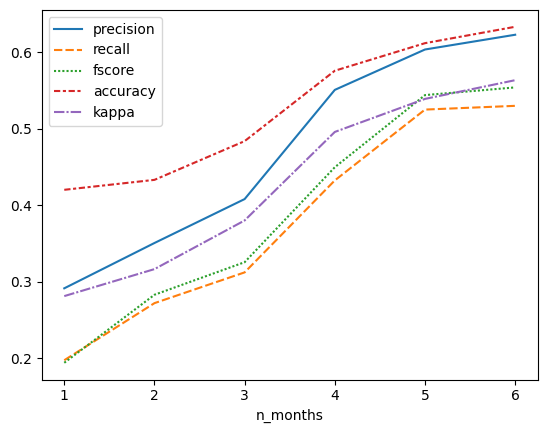

In [81]:
sns.lineplot(data=rf_test_scores)

In [64]:
rf_best_models_hyperparams = get_best_models_hyperparams(rf_results, rf_hyperparameters)
rf_best_models_hyperparams

,n_months,n_estimators,max_depth
0,1,120,10
1,2,190,16
2,3,380,19
3,4,450,17
4,5,380,19
5,6,380,19


In [88]:
rf_cross_val_scores = get_cross_val_scores(rf_results)
rf_cross_val_scores.head()

,n_months,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,...,split2_test_fscore,mean_test_fscore,std_test_fscore,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa
0,1,7.370475,0.009758,0.203622,0.002576,210,4,"{'n_estimators': 210, 'max_depth': 4}",0.413681,0.405945,...,0.322079,0.328246,0.015061,94,0.241618,0.260971,0.258536,0.253708,0.008607,93
1,1,27.915622,0.916207,0.371727,0.042255,280,19,"{'n_estimators': 280, 'max_depth': 19}",0.422638,0.436889,...,0.401712,0.403344,0.015289,2,0.293189,0.318691,0.298438,0.303439,0.010995,7
2,1,20.327585,1.269749,0.368862,0.044080,320,7,"{'n_estimators': 320, 'max_depth': 7}",0.423453,0.425081,...,0.373214,0.375514,0.011742,77,0.279759,0.297248,0.287861,0.288289,0.007146,74
3,1,33.415080,1.393729,0.403189,0.004466,390,14,"{'n_estimators': 390, 'max_depth': 14}",0.419788,0.440147,...,0.403005,0.402490,0.017026,4,0.289288,0.321766,0.304233,0.305096,0.013273,1
4,1,10.554142,0.855736,0.289420,0.005627,400,3,"{'n_estimators': 400, 'max_depth': 3}",0.410016,0.378257,...,0.309574,0.301701,0.006583,97,0.228627,0.215265,0.245567,0.229820,0.012399,97


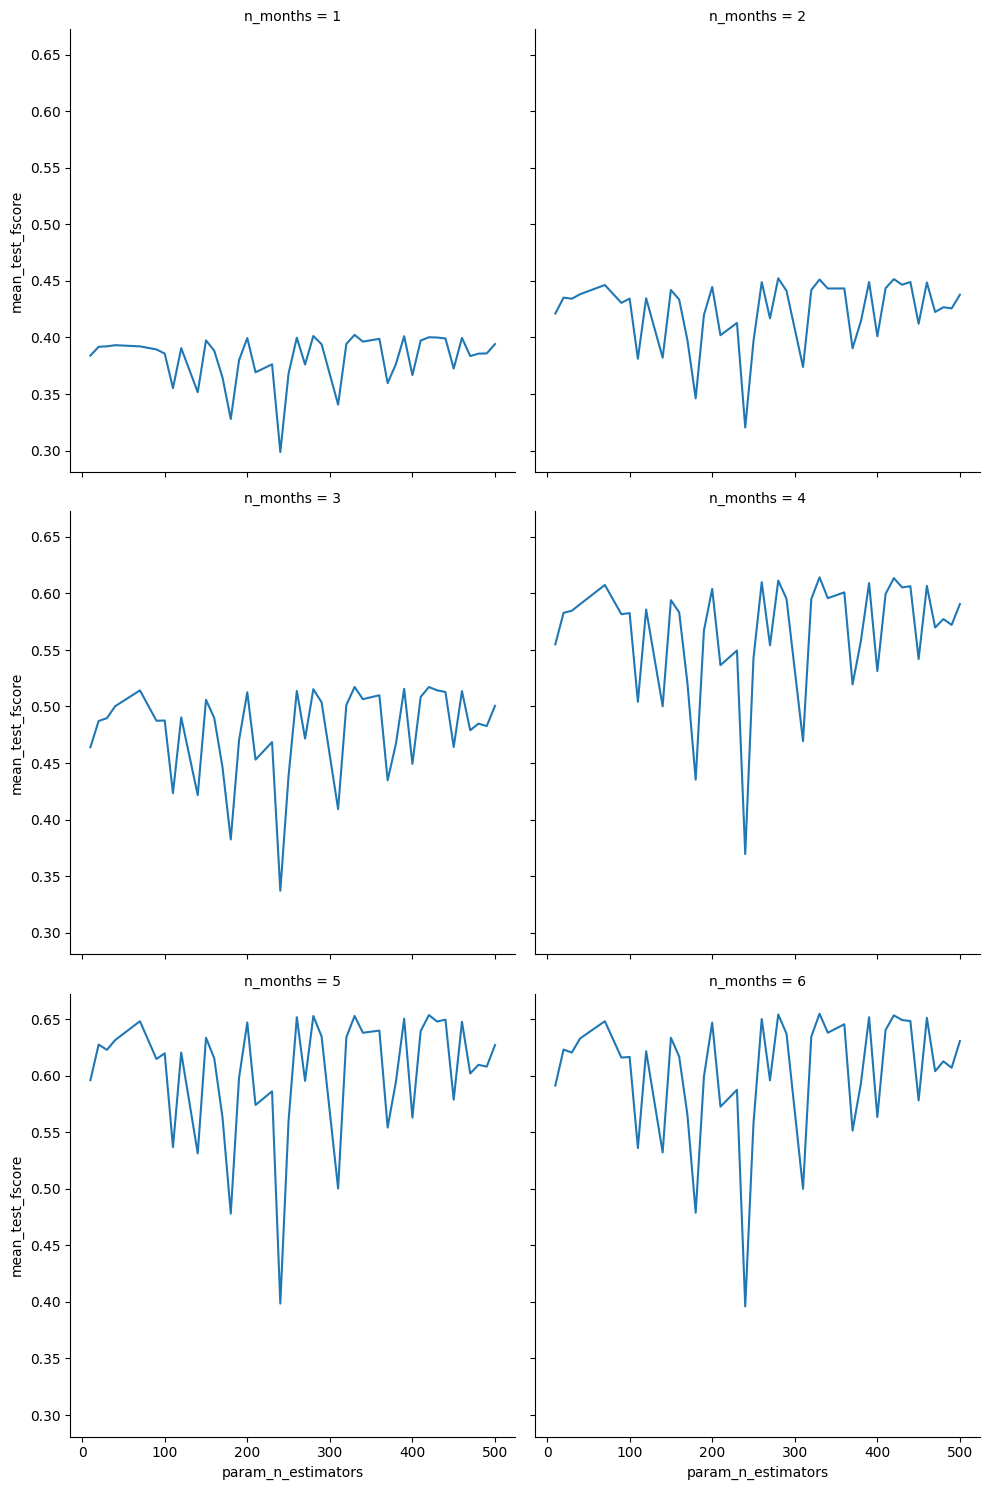

In [107]:
plot_cross_val_scores(rf_cross_val_scores, "n_estimators", "fscore")